## PS3: Decision Trees and Ensemble Methods
### Omer Seyfeddin Koc / 3 April 2023

Implement the decision tree learning algorithm described in class(without post-pruning). Your program can assume that all features/attributes are real-valued attributes (no categorical attributes), except for the target attribute that is discrete and may take on a finite set of possible values. You may also assume that the data contains no missing attributes. Use information gain as your splitting criterion and allow only binary splits.

Your algorithm should accept an optional parameter that sets the limit of the depth of the tree that will be generated when training. If the depth limit has not been set, the entire tree should be learned. If the depth limit has been set, only nodes up to that depth limit should be built.

Run your algorithm on the Iris flower data set (available at $sklearn.datasets$), and display the resulting decision tree.}

Run DecisionTreeClassifier from scikit-learn on the same data set, and compare its generated decision tree to the one built by your algorithm.

## 1) Implement the decision tree learning algorithm described in class(without post-pruning). 

In [6]:
# Import required libraries 
import numpy as np
import pandas as pd
from collections import Counter

In [7]:
class DecisionTreeClassifier_user_defined:

    # Define a nested class called Node to represent a node in the decision tree
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
            '''Initialize a node in the decision tree.'''
            self.feature = feature  # index of feature used for splitting
            self.threshold = threshold  # threshold value used for splitting
            self.left = left  # left child node
            self.right = right  # right child node
            self.label = label  # class label (for leaf nodes only)
    
    # Define the constructor for the DecisionTreeClassifier class
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # maximum depth of the decision tree

    # Define a private method to find the best split point for the decision tree
    def _best_split(self, X, y):
        # Initialize best_gain to -1 and split_idx and split_threshold to None
        best_gain = -1
        split_idx, split_threshold = None, None
        # Iterate over each feature in the dataset
        for feature_idx in range(X.shape[1]):
            # Iterate over each unique value of the current feature
            for threshold in np.unique(X[:, feature_idx]):
                # Calculate the information gain for the current feature and threshold
                gain = self._information_gain(X, y, feature_idx, threshold)
                # If the current gain is greater than the best_gain, 
                # update the best_gain, split_idx, and split_threshold
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
        
        # Return the split_idx and split_threshold values for the best split point
        return split_idx, split_threshold
    
    # Define a recursive helper function to build the decision tree
    def _grow_tree(self, X, y, depth=0):
        # If the maximum depth has been reached or all instances in y belong 
        # to the same class, create a leaf node
        if depth == self.max_depth or len(set(y)) == 1:
            label = max(set(y.tolist()), key=y.tolist().count)
            print('Depth:', depth,'Class:',label)
            return self.Node(label=label)

        # Find the best feature and threshold to split on
        feature_idx, threshold = self._best_split(X, y)
        print('Depth ', depth,' => ','SplitID/Treshold: ',feature_idx,' - <',threshold,sep='')
        # Split the data into left and right subsets based on the chosen feature and threshold
        left_idxs, right_idxs = self._split(X[:, feature_idx], threshold)

        # If one of the subsets is empty, 
        # create a leaf node with the majority class label of the parent node
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            label = max(set(y.tolist()), key=y.tolist().count)
            return self.Node(label=label)

        # Recursively build the left and right child nodes
        left_child = self._grow_tree(X[left_idxs, :], y[left_idxs], depth=depth+1)
        right_child = self._grow_tree(X[right_idxs, :], y[right_idxs], depth=depth+1)
        # Create a new node representing the chosen split and its child nodes
        return self.Node(feature=feature_idx, threshold=threshold, left=left_child, right=right_child)

    def _information_gain(self, X, y, feature_idx, threshold):
        parent_entropy = self._entropy(y)
        
        # split the data
        left_idxs, right_idxs = self._split(X[:, feature_idx], threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted average of the child entropies
        num_left, num_right = len(left_idxs), len(right_idxs)
        entropy_left = self._entropy(y[left_idxs])
        entropy_right = self._entropy(y[right_idxs])
        child_entropy = (num_left / len(y)) * entropy_left + (num_right / len(y)) * entropy_right
        
        # calculate the information gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    # Define a private method to calculate entropy of a given set of labels
    def _entropy(self, y):
        # Create a Counter object to count the frequency of each label
        counter = Counter(y)
        # Initialize entropy to zero
        entropy = 0
        # Iterate over each label in the Counter object
        for label in counter:
            # Calculate the probability of the label
            p = counter[label] / len(y)
            # Update entropy using the formula for entropy calculation
            entropy -= p * np.log2(p)
        # Return the final entropy value
        return entropy
    
    # Define a private method to split the data based on a given threshold value
    def _split(self, X, threshold):
        # Find the indices of all data points that are less than or equal to the threshold
        left_idxs = np.argwhere(X <= threshold).flatten()
        # Find the indices of all data points that are greater than the threshold
        right_idxs = np.argwhere(X > threshold).flatten()
        # Return the indices of the left and right data points
        return left_idxs, right_idxs

    # Define the fit method for training the decision tree
    def fit(self, X, y):
        self.num_classes = len(set(y))  # number of unique classes in the target variable
        self.tree = self._grow_tree(X, y)  # build the decision tree
    
    # Define the predict method for making predictions with the trained decision tree
    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])  # predict the class label for each input in X
    
    # Define a method to predict the label for a given input using a decision tree.
    def _predict(self, inputs):
        # Start from the root node of the tree.
        node = self.tree
        # Traverse the tree until a leaf node is reached.
        while node.label is None:
            # Check if the input value for the current node's feature is less than its threshold.
            if inputs[node.feature] < node.threshold:
                # If so, traverse to the left child node.
                node = node.left
            else:
                # Otherwise, traverse to the right child node.
                node = node.right
        # Return the label of the leaf node.
        return node.label

## 2) Run your algorithm on the Iris flower data set (available at sklearn.datasets), and display the resulting decision tree.

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

'''INDICATE DEPTH LIMIT (max_depth)'''
# If the depth limit has been set, only nodes up to that depth limit should be built.
# If the depth limit has not been set, the entire tree should be learned.
clf_used_defined = DecisionTreeClassifier_user_defined(max_depth=4)
clf_used_defined.fit(X_train, y_train)

# make predictions on the testing data
y_pred = clf_used_defined.predict(X_test)

# evaluate the performance of the classifier
accuracy_user_defined = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy_user_defined:.4f}')

Depth 0 => SplitID/Treshold: 2 - <1.9
Depth: 1 Class: 0
Depth 1 => SplitID/Treshold: 3 - <1.6
Depth 2 => SplitID/Treshold: 2 - <4.9
Depth: 3 Class: 1
Depth 3 => SplitID/Treshold: 0 - <6.0
Depth: 4 Class: 1
Depth: 4 Class: 2
Depth 2 => SplitID/Treshold: 2 - <4.8
Depth 3 => SplitID/Treshold: 1 - <3.0
Depth: 4 Class: 2
Depth: 4 Class: 1
Depth: 3 Class: 2
Test set accuracy: 0.9333


### 2.a) Tree Explanation:

The tree of the classification that I created above is explained below.

First of all, the corresponding ID values given above are as follows:

SepalLength : 0
SepalWidth : 1
PetalLength : 2
PetalWidth : 3

In addition, the ID value and corresponding name of the Classes are as follows:

Setosa: 0
Versicolor: 1
Virginia: 2


As seen above, our tree is output based on depth. Class ids correspond to the classes given above. Likewise, the splitID values correspond to the features given above. The treshold value next to each splitID is the treshold value for that node. A visualized version of these structure:

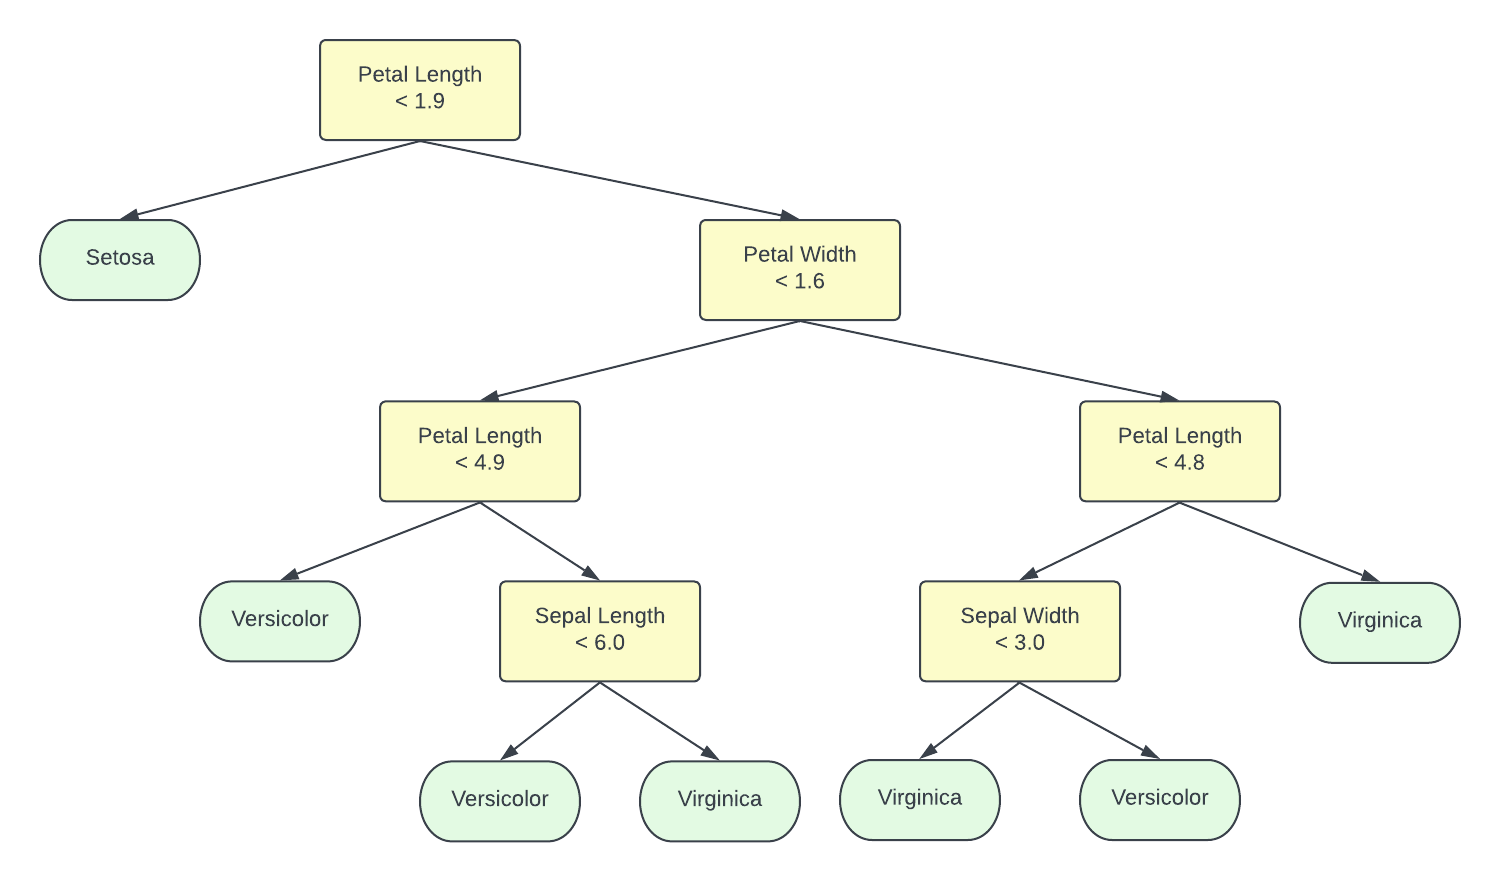

## 3) Run DecisionTreeClassifier from scikit-learn on the same data set, and compare its generated decision tree to the one built by your algorithm.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf_sklearn=DecisionTreeClassifier()
clf_sklearn.fit(X_train, y_train)
print(f'Test set accuracy: {clf_sklearn.score(X_test, y_test):.4f}')

Test set accuracy: 0.9667


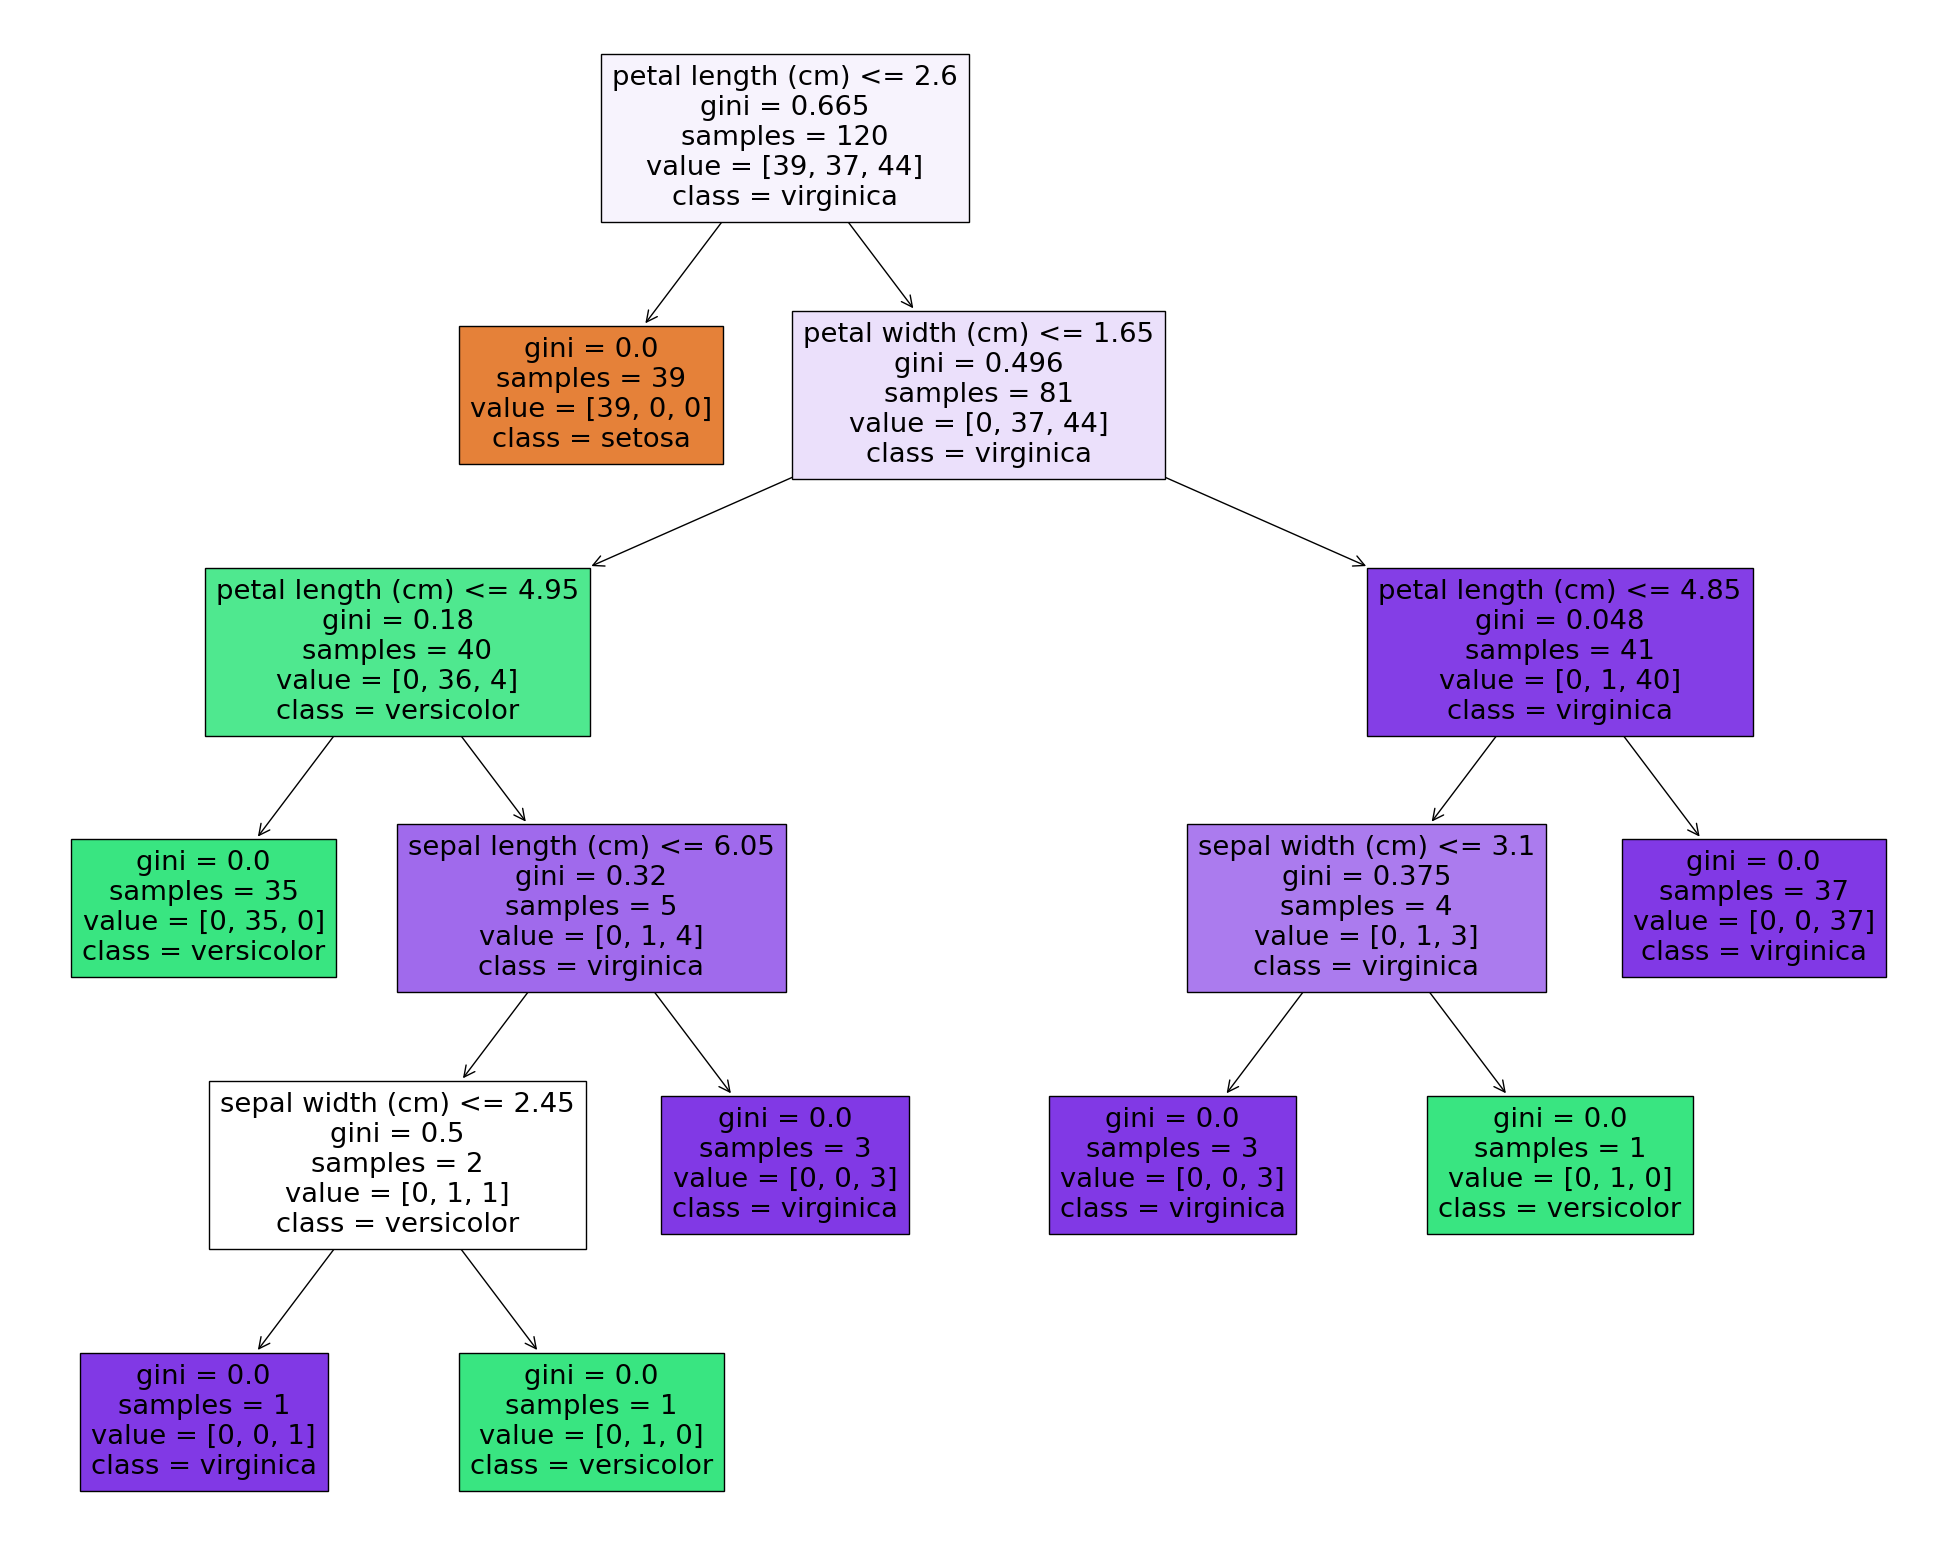

In [10]:
from matplotlib import pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_sklearn, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

Based on the accuracy results you provided, it seems like the built-in classifier performed slightly better than my algorithm. However, accuracy alone is not always the best measure of performance, and it would be helpful to further evaluate the two models using other metrics. It would also be useful to compare the structure of the decision trees generated by each algorithm to see if there are any notable differences or similarities.

When I look at both decision trees in general, in scenarios where the Splitting attributes values are the same, the treshold values of the model I created and the treshold values of the built-in decision tree are very close, even if they are not exactly the same. The fact that there is a 3% difference in accuracy also explains this situation. In general, both models are very similar to each other.

## Thanks!